<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/Attempt4_MobileNetV2_cleanedversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import cv2

# Set the category and paths
category = "bottle"
drive_root = f"/content/drive/MyDrive/Colab Notebooks/{category}"
train_dir = os.path.join(drive_root, "train", "good")
test_dir = os.path.join(drive_root, "test")

# Get training images (only 'good')
train_images = glob.glob(f"{train_dir}/*.png")

# Get test images: both 'good' and defective
test_images_good = glob.glob(f"{test_dir}/good/*.png")
test_images_defect = []
defect_classes = []

for defect_class in os.listdir(test_dir):
    class_path = os.path.join(test_dir, defect_class)
    if os.path.isdir(class_path) and defect_class != "good":
        defect_classes.append(defect_class)
        test_images_defect += glob.glob(f"{class_path}/*.png")

test_images = test_images_good + test_images_defect

# Count defect classes (excluding 'good')
num_defect_classes = len(defect_classes)

# Example image to get shape
sample_img = cv2.imread(train_images[0])
height, width, channels = sample_img.shape

# Output summary
print("📊 Dataset Summary for 'bottle':")
print(f"• Number of defect classes: {num_defect_classes}")
print(f"• Types of defect classes: {defect_classes}")
print(f"• Total images used: {len(train_images) + len(test_images)}")
print(f"    - Training images (only 'good'): {len(train_images)}")
print(f"    - Test images (good + defective): {len(test_images)}")
print(f"• Image dimensions: {width} x {height} x {channels}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Dataset Summary for 'bottle':
• Number of defect classes: 3
• Types of defect classes: ['broken_small', 'broken_large', 'contamination']
• Total images used: 292
    - Training images (only 'good'): 209
    - Test images (good + defective): 83
• Image dimensions: 900 x 900 x 3


In [ ]:
file_paths = glob.glob("/content/drive/MyDrive/Colab Notebooks/bottle/**/*/*.png", recursive=True)

In [ ]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/355 [00:00<?, ?it/s]

(355, 900, 900, 3)


Classes found: ['broken_large', 'broken_small', 'contamination', 'good']


<ipython-input-24-b95ca385b939>:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


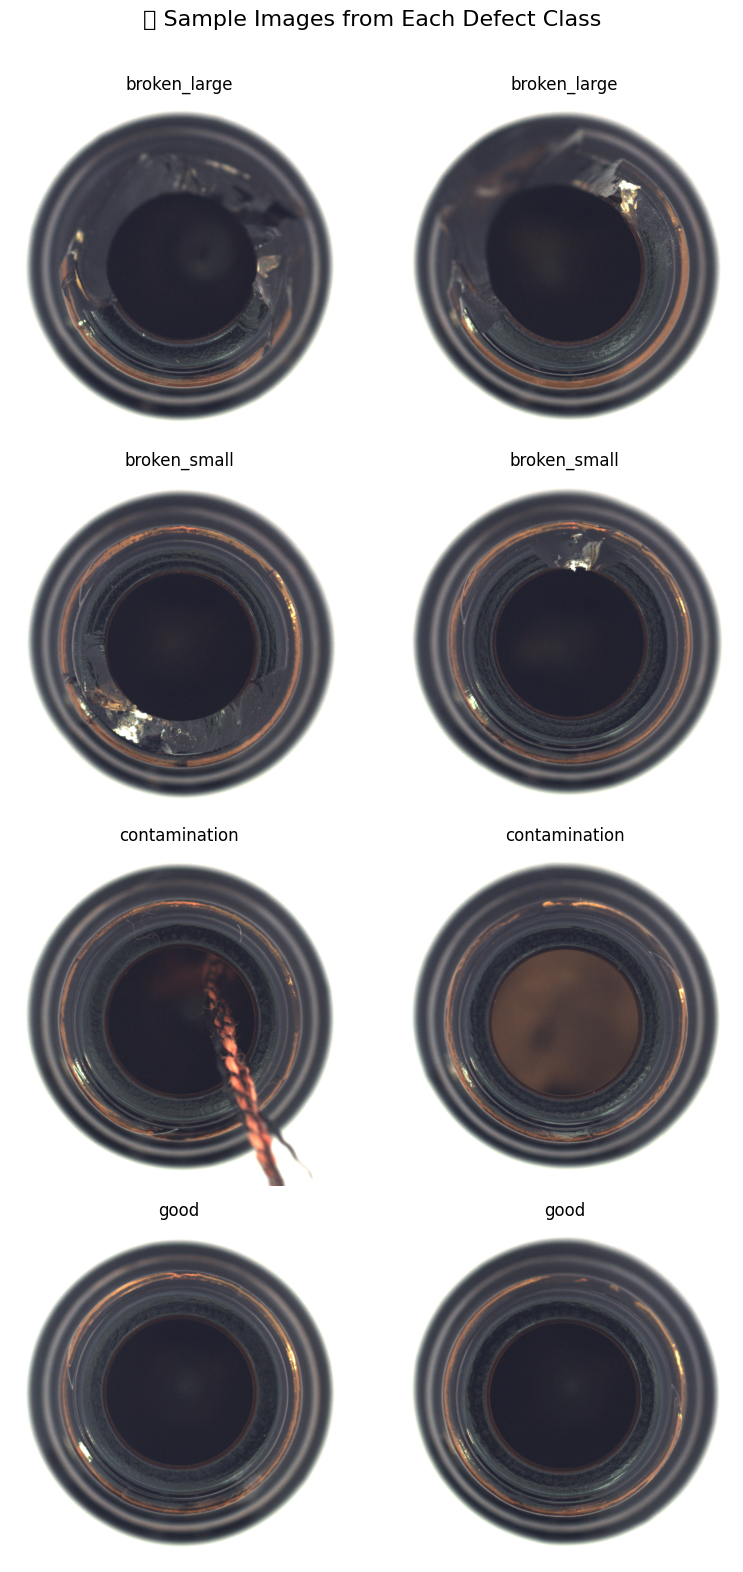

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your test directory
test_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/test"

# Get all class names in the test directory
classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print(f'Classes found: {classes}')

# Prepare plot
fig, axs = plt.subplots(len(classes), 2, figsize=(8, 4 * len(classes)))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(test_dir, class_name)
    image_paths = glob.glob(f"{class_folder}/*.png")

    # If there are fewer than 2 images, fill with duplicates
    if len(image_paths) < 2:
        images = image_paths * 2
    else:
        images = random.sample(image_paths, 2)

    for j in range(2):
        img = cv2.imread(images[j])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{class_name}')

# Super title and layout
plt.suptitle("🔍 Sample Images from Each Defect Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Paths
train_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/train/good"
test_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/test"

# --- Load Training Data (GOOD + SELECTED DEFECT) ---
train_x = []
train_y = []

# Good images (label = 0)
good_train = glob.glob(os.path.join(train_dir, "*.png"))
for path in good_train:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_x.append(img)
    train_y.append(0)

# Select limited defect images from test set (label = 1)
defect_classes = ['broken_large', 'broken_small', 'contamination']
for cls in defect_classes:
    defect_imgs = sorted(glob.glob(f"{test_dir}/{cls}/*.png"))[:10]  # pick 10 from each
    for path in defect_imgs:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_x.append(img)
        train_y.append(1)

# Convert training data
x_train = np.transpose(np.array(train_x), (0, 3, 1, 2))  # (N, C, H, W)
y_train = np.array(train_y, dtype=np.int64)
print(f"✅ x_train: {x_train.shape}, y_train: {y_train.shape}")
print("📊 Training label counts:", np.bincount(y_train))

# --- Load Test Data (full test set: good + all defects) ---
x_test = []
y_test = []

for cls in os.listdir(test_dir):
    label = 0 if cls == "good" else 1
    for path in glob.glob(f"{test_dir}/{cls}/*.png"):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_test.append(img)
        y_test.append(label)

x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))
y_test = np.array(y_test, dtype=np.int64)
print(f"✅ x_test: {x_test.shape}, y_test: {y_test.shape}")
print("📊 Test label counts:", np.bincount(y_test))

✅ x_train: (239, 3, 900, 900), y_train: (239,)
📊 Training label counts: [209  30]
✅ x_test: (83, 3, 900, 900), y_test: (83,)
📊 Test label counts: [20 63]


In [ ]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch

# ✅ Shared transform for MobileNetV2
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required input size for MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# ✅ Dataset with labels (for both training and testing)
class LabeledImageDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = np.transpose(self.x[idx], (1, 2, 0))  # Convert to HWC
        img = Image.fromarray(img.astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        return img, self.y[idx]


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = LabeledImageDataset(x_train, y_train, transform=image_transform)
val_dataset   = LabeledImageDataset(x_test, y_test, transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## B. Defining Neural Networks

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

# Load pretrained MobileNetV2 from torchvision
model = models.mobilenet_v2(weights='IMAGENET1K_V1')

# Optional: Freeze the feature extractor if you only want to fine-tune the classifier
for param in model.features.parameters():
    param.requires_grad = False  # Comment this out if you want to fine-tune the whole model

# Replace the classifier to match 2 output classes (good vs defect)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print summary
print(model)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.1MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * 50, eta_min=0)

# Training parameters
epochs = 50
best_val_acc = -1
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(epochs), desc="Training MobileNetV2"):
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100. * train_correct / total_train

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total

    # Scheduler step
    lr_scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model_mobilenetv2.pth")

    # Logging
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | Best Val Acc: {best_val_acc:.2f}%")

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)




Training MobileNetV2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.4965 | Train Acc: 80.33% | Val Loss: 2.9584 | Val Acc: 24.10% | Best Val Acc: 24.10%
Epoch 2/50 | Train Loss: 0.3101 | Train Acc: 87.45% | Val Loss: 0.8232 | Val Acc: 36.14% | Best Val Acc: 36.14%
Epoch 3/50 | Train Loss: 0.2816 | Train Acc: 95.82% | Val Loss: 1.3196 | Val Acc: 26.51% | Best Val Acc: 36.14%
Epoch 4/50 | Train Loss: 0.2181 | Train Acc: 88.28% | Val Loss: 1.1954 | Val Acc: 36.14% | Best Val Acc: 36.14%
Epoch 5/50 | Train Loss: 0.1602 | Train Acc: 94.14% | Val Loss: 0.4740 | Val Acc: 81.93% | Best Val Acc: 81.93%
Epoch 6/50 | Train Loss: 0.1358 | Train Acc: 97.07% | Val Loss: 0.6721 | Val Acc: 63.86% | Best Val Acc: 81.93%
Epoch 7/50 | Train Loss: 0.1278 | Train Acc: 94.14% | Val Loss: 0.6657 | Val Acc: 66.27% | Best Val Acc: 81.93%
Epoch 8/50 | Train Loss: 0.1068 | Train Acc: 95.40% | Val Loss: 0.4195 | Val Acc: 85.54% | Best Val Acc: 85.54%
Epoch 9/50 | Train Loss: 0.0898 | Train Acc: 97.49% | Val Loss: 0.5608 | Val Acc: 75.90% | Best Val Acc:

In [ ]:
print("Train label counts:", np.bincount(y_train))
print("Test label counts:", np.bincount(y_test))  # ✅ corrected!


Train label counts: [209  30]
Test label counts: [20 63]


### Visualizing model performance

<ipython-input-35-c2bf001be67c>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-35-c2bf001be67c>:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


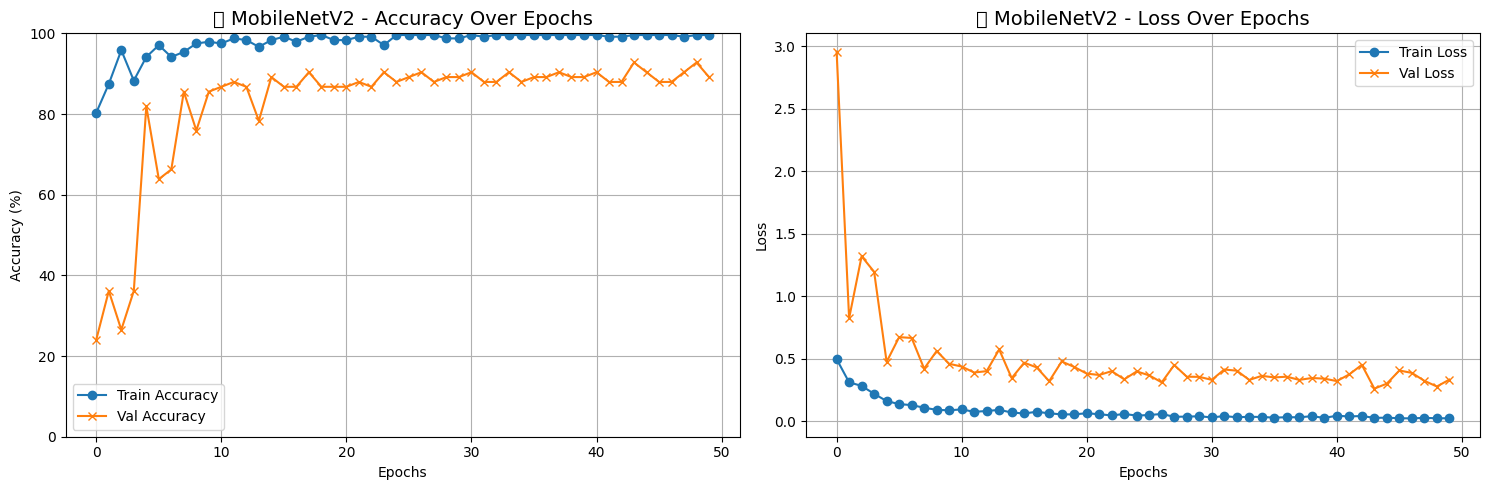

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 📈 Accuracy Plot
ax[0].plot(train_accuracies, label='Train Accuracy', marker='o')
ax[0].plot(val_accuracies, label='Val Accuracy', marker='x')
ax[0].set_title('📊 MobileNetV2 - Accuracy Over Epochs', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()
ax[0].grid(True)
ax[0].set_ylim(0, 100)

# 📉 Loss Plot
ax[1].plot(train_losses, label='Train Loss', marker='o')
ax[1].plot(val_losses, label='Val Loss', marker='x')
ax[1].set_title('📉 MobileNetV2 - Loss Over Epochs', fontsize=14)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Final layout
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/model_classification_mobilenetv2.pth")


## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [ ]:
import torch
import os

# Define the path where the model was saved
model_path = "/content/drive/MyDrive/Colab Notebooks/model_classification_mobilenetv2.pth"

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if model file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model file not found at: {model_path}")

# Load the trained model and move to the correct device
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate on test/validation set
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = model(images)
        predicted = outputs.argmax(-1)

        # Uncomment for debugging if needed
        # print("🔍 Predicted:", predicted.cpu().numpy())
        # print("🎯 Ground Truth:", labels.cpu().numpy())

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

# Final test accuracy
test_acc = 100. * test_correct / test_total
print(f'✅ Final Test Accuracy (MobileNetV2): {test_acc:.2f}%')


✅ Final Test Accuracy (MobileNetV2): 89.16%
